In [82]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt

In [93]:

# Initialize wandb API
api = wandb.Api()

Models = {"base":{'sweep_ids':["y5j1uqkv", "hbume7i5"]},
           "taylor":{'sweep_ids':["e7nd5dzv"]}, 
           "continuous":{'sweep_ids':["xmxt392x"]},
           "dttrain":{'sweep_ids':["irxp75av"]},  
           "reparam":{'sweep_ids':["sjpedyxt", "r2s3dj5j"]}, 
           "s4_init":{'sweep_ids':["wwui18wq", "tqyn6vdh"]},
           "ComplexLIF":{'sweep_ids':["wfvufo6d"]}}


sweep_params = ['lr', 'pdrop', 'scheduler_patience', 'scheduler_factor', 'dt_max', 'model_name']

In [94]:
# Function to retrieve all runs for a given sweep_id
def get_runs_from_sweep(sweep_id):
    sweep = api.sweep(f"maximes_crew/S3_SHD_runs/{sweep_id}")
    runs = sweep.runs
    data = []
    for run in runs:
        config = run.config
        summary = run.summary
        n_layers = config.get('nb_layers')
        n_hiddens = config.get('nb_hiddens')
        lr = config.get('lr')
        dt_min = config.get('dt_min')
        dt_max = config.get('dt_max')
        pdrop = config.get('pdrop')
        sched_patience = config.get('scheduler_patience')
        sched_factor = config.get('scheduler_factor')
        best_valid_acc = summary.get('best valid acc')

        if best_valid_acc is not None:
            data.append({
                'n_layers': n_layers,
                'n_hiddens': n_hiddens,
                'lr': lr,
                'dt_min': dt_min,
                'dt_max': dt_max,
                'pdrop' : pdrop,
                'scheduler_patience' : sched_patience,
                'scheduler_factor' : sched_factor,
                'best_valid_acc': best_valid_acc
            })
    return pd.DataFrame(data)

# Create a dictionary to hold dataframes for each model
all_model_data = []

# Loop over each model in the Models dictionary
for model_name, model_info in Models.items():
    sweeps = model_info['sweep_ids']
    # Create an empty list to store dataframes for each sweep
    dfs = []
    
    # For each sweep_id in the model's sweep_ids, retrieve the runs and store them in a list of dataframes
    for sweep_id in sweeps:
        df = get_runs_from_sweep(sweep_id)
        if not df.empty:
            df['model_name'] = model_name  # Add the model name to the DataFrame
            all_model_data.append(df)
    
    # # Concatenate all dataframes for the current model
    # if dfs:
    #     Models[model_name]['dataframe'] = pd.concat(dfs, ignore_index=True)
    #     df['model_name'] = model_name  # Add the model name to the DataFrame
    #     all_model_data.append(df)

# Combine all the data into one DataFrame
df_all = pd.concat(all_model_data, ignore_index=True)


In [95]:
sweep_params

['lr',
 'pdrop',
 'scheduler_patience',
 'scheduler_factor',
 'dt_max',
 'model_name']

In [96]:
df_all

,n_layers,n_hiddens,lr,dt_min,dt_max,pdrop,scheduler_patience,scheduler_factor,best_valid_acc,model_name
0,3,512,0.001,0.01,0.7,0.50,10,0.7,0.908341,base
1,3,512,0.001,0.01,0.7,0.50,10,0.7,0.916785,base
2,3,512,0.001,0.01,0.7,0.50,10,0.7,0.923295,base
3,3,512,0.001,0.01,0.7,0.25,10,0.7,0.916312,base
4,3,512,0.001,0.01,0.7,0.25,10,0.7,0.903961,base
...,...,...,...,...,...,...,...,...,...,...
312,3,512,0.005,0.01,0.5,0.25,10,0.7,0.939986,ComplexLIF
313,3,512,0.005,0.01,0.5,0.25,10,0.7,0.959280,ComplexLIF
314,3,512,0.005,0.01,0.5,0.25,10,0.7,0.959320,ComplexLIF
315,3,512,0.005,0.01,0.5,0.25,10,0.7,0.955571,ComplexLIF


In [97]:
# Group by the sweep params and model_name, then compute the mean of best_valid_acc for each group
df_grouped = df_all.groupby(sweep_params).agg({'best_valid_acc': ['mean', 'std']}).reset_index()

# Calculate the number of runs for each unique configuration
df_all['run_count'] = df_all.groupby(sweep_params).transform('size')

df_grouped['run_count'] = df_grouped.apply(lambda x: df_all[
    (df_all[sweep_params].apply(tuple, axis=1) == tuple(x[sweep_params]))
]['run_count'].iloc[0], axis=1)

# Sort the grouped DataFrame by best_valid_acc in descending order
df_grouped_sorted = df_grouped.sort_values(by=('best_valid_acc', 'mean'), ascending=False).reset_index(drop=True)

In [98]:
df_grouped_sorted[0:10]

lr pdrop scheduler_patience scheduler_factor dt_max  model_name  \
                                                                        
0  0.005  0.25                 10              0.7    0.5  ComplexLIF   
1  0.005  0.10                 10              0.7    0.5     s4_init   
2  0.010  0.10                 10              0.7    0.5     s4_init   
3  0.005  0.25                 10              0.7    0.5     s4_init   
4  0.010  0.25                 10              0.7    0.5     s4_init   
5  0.001  0.50                 10              0.7    0.7     reparam   
6  0.001  0.25                 10              0.7    0.7     s4_init   
7  0.050  0.10                 10              0.7    0.7     s4_init   
8  0.001  0.50                 10              0.7    0.7     s4_init   
9  0.001  0.25                 10              0.7    0.7     reparam   

  best_valid_acc           run_count  
            mean       std            
0       0.955982  0.009663         5  
1       0.949092  0.003415         5  
2       0.948027  0.006617         5  
3       0.943793  0.000419         2  
4       0.942464  0.004320         5  
5       0.933341  0.005332         5  
6       0.931929  0.013461         5  
7       0.929995  0.010728         5  
8       0.929285  0.010879         5  
9       0.929253  0.012774         5

In [99]:
# Flatten the multi-level column names for easier access
df_grouped.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_grouped.columns]

# Extract the configuration with the best mean best_valid_acc for each model
best_runs = df_grouped.loc[df_grouped.groupby('model_name_')['best_valid_acc_mean'].idxmax()]

In [100]:
best_runs

,lr_,pdrop_,scheduler_patience_,scheduler_factor_,dt_max_,model_name_,best_valid_acc_mean,best_valid_acc_std,run_count_
20,0.005,0.25,10,0.7,0.5,ComplexLIF,0.955982,0.009663,5
13,0.001,0.50,10,0.7,0.7,base,0.924445,0.009354,8
31,0.050,0.25,10,0.7,0.7,continuous,0.924755,0.008000,5
2,0.001,0.10,10,0.7,0.7,dttrain,0.902131,0.006034,5
16,0.001,0.50,10,0.7,0.7,reparam,0.933341,0.005332,5
19,0.005,0.10,10,0.7,0.5,s4_init,0.949092,0.003415,5
29,0.050,0.10,10,0.7,0.7,taylor,0.921686,0.006752,5


In [101]:
model_order = list(Models.keys())

# Convert the 'model_name' column to a categorical type with the specified order
best_runs['model_name_'] = pd.Categorical(best_runs['model_name_'], categories=model_order, ordered=True)

# Sort best_runs based on the categorical model_name_ column to enforce the desired order
best_runs_sorted = best_runs.sort_values('model_name_').reset_index(drop=True)


/tmp/ipykernel_1289224/1343704773.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(best_runs_sorted['model_name_'], best_runs_sorted['best_valid_acc_mean'], yerr=best_runs_sorted['best_valid_acc_std'], fmt='o', capsize=5, linestyle='-', marker='s')


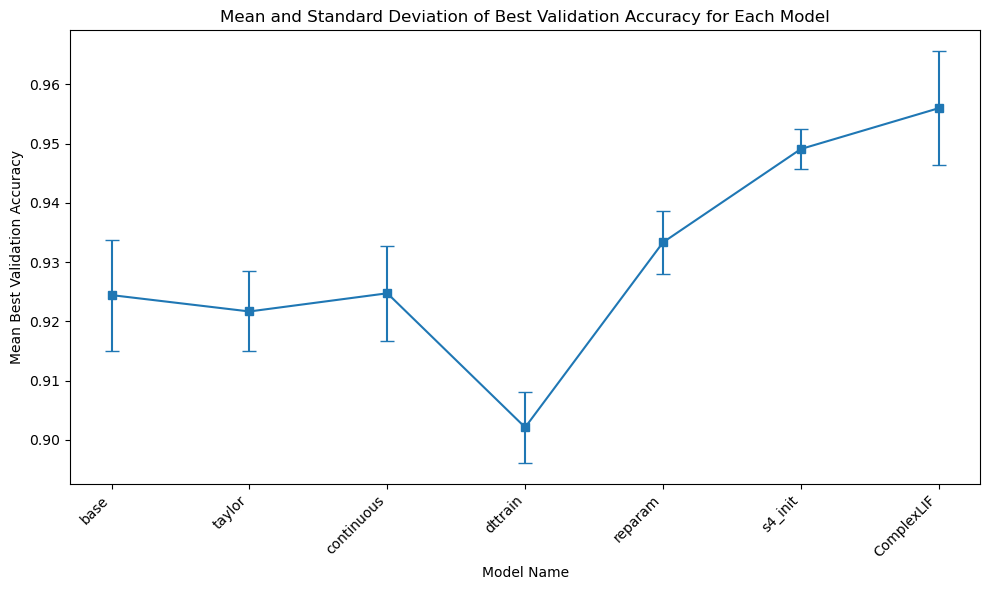

In [102]:
# Plotting mean and std deviation in the order of the model names
plt.figure(figsize=(10, 6))
plt.errorbar(best_runs_sorted['model_name_'], best_runs_sorted['best_valid_acc_mean'], yerr=best_runs_sorted['best_valid_acc_std'], fmt='o', capsize=5, linestyle='-', marker='s')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Model Name')
plt.ylabel('Mean Best Validation Accuracy')
plt.title('Mean and Standard Deviation of Best Validation Accuracy for Each Model')
plt.tight_layout()
plt.show()